In [1]:
import logging
from importlib import reload

import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import homework_utils

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.test.gpu_device_name())
tf.keras.mixed_precision.set_global_policy('mixed_float16')

logging.getLogger().setLevel(logging.INFO)

Num GPUs Available:  1
/device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 Ti, compute capability 7.5


In [3]:
# Load data into pandas DataFrame
df = pd.read_parquet("dataset/unscaled_train_data.parquet")

# Define the feature and target columns
feature_cols = df.columns[:-1]
target_col = df.columns[-1]
O = len(df[target_col].unique())
I = len(feature_cols)


# Define a function to create the Keras model
def create_model(hidden_size: int, lr: float = None, m: float = None):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=len(feature_cols), activation="sigmoid"))
    model.add(Dense(O, activation="softmax"))
    if lr and m:
        optimizer = SGD(learning_rate=lr, momentum=m)
    else:
        optimizer = Adam(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_crossentropy", "mean_squared_error", "accuracy"],
    )
    return model

In [4]:
hidden_layer_matrice = [
    {"hidden_size": O},
    {"hidden_size": int((I + O) / 2)},
    {"hidden_size": I + O},
]

reload(homework_utils)

hiddensize_test_resuts = homework_utils.wrap_test_case(
    hidden_layer_matrice, create_model, df[feature_cols].values, df[target_col].values
)


INFO:root:Running testcase {'hidden_size': 5}
INFO:root:Running testcase {'hidden_size': 10}
INFO:root:Running testcase {'hidden_size': 20}


In [5]:
for result in hiddensize_test_resuts:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'hidden_size': 5}
Validation Cross Entropy: 0.2340 (+/- 0.0183)
Validation MSE: 0.0227 (+/- 0.0020)
Validation Accuracy: 0.9258 (+/- 0.0070)
{'hidden_size': 10}
Validation Cross Entropy: 0.1144 (+/- 0.0076)
Validation MSE: 0.0105 (+/- 0.0008)
Validation Accuracy: 0.9665 (+/- 0.0031)
{'hidden_size': 20}
Validation Cross Entropy: 0.0621 (+/- 0.0040)
Validation MSE: 0.0057 (+/- 0.0003)
Validation Accuracy: 0.9819 (+/- 0.0009)


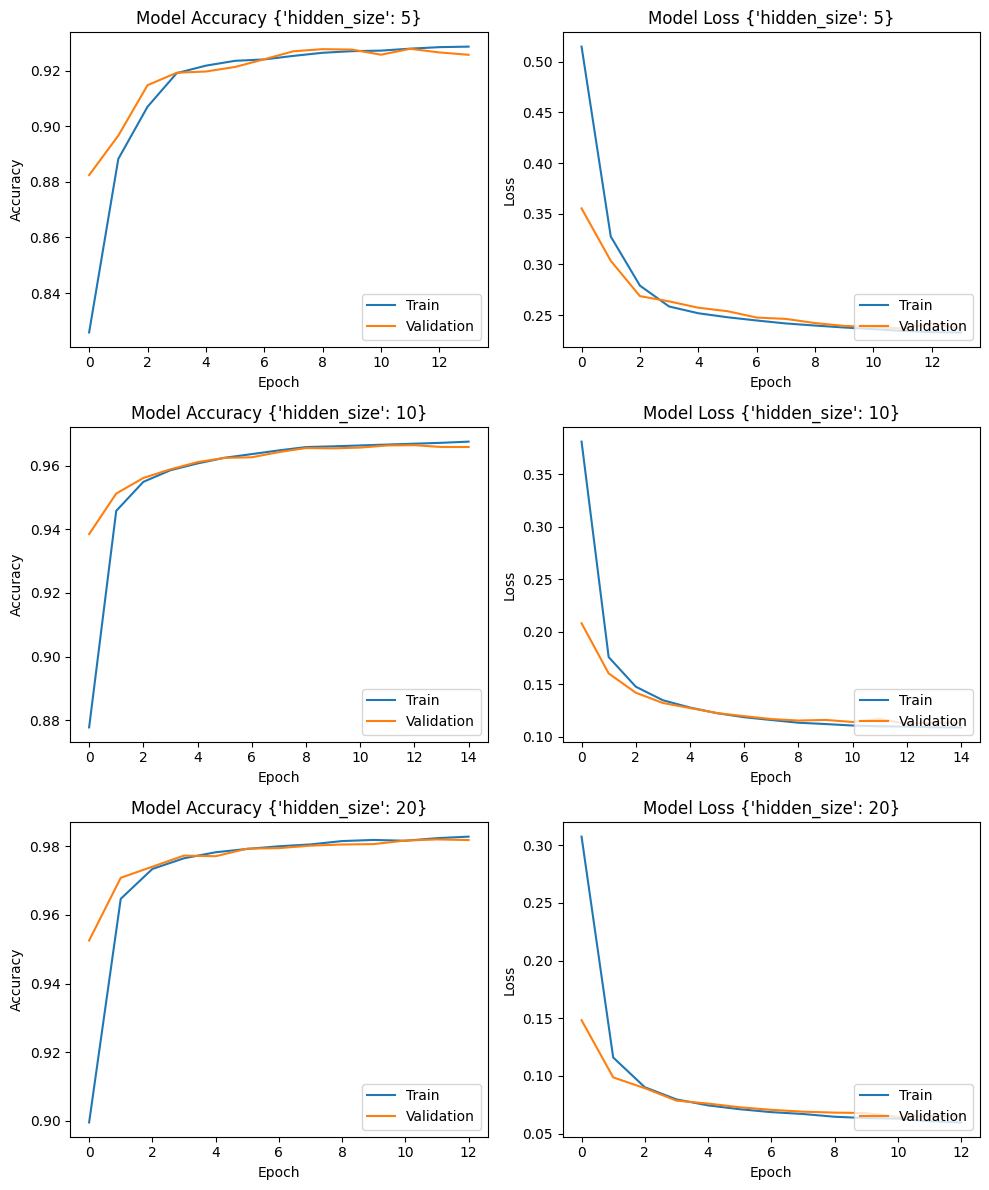

In [6]:
reload(homework_utils)

# set up the figure
homework_utils.figure_from_histories(
    [I.histories[0] for I in hiddensize_test_resuts],
    [I.testcase for I in hiddensize_test_resuts],
)

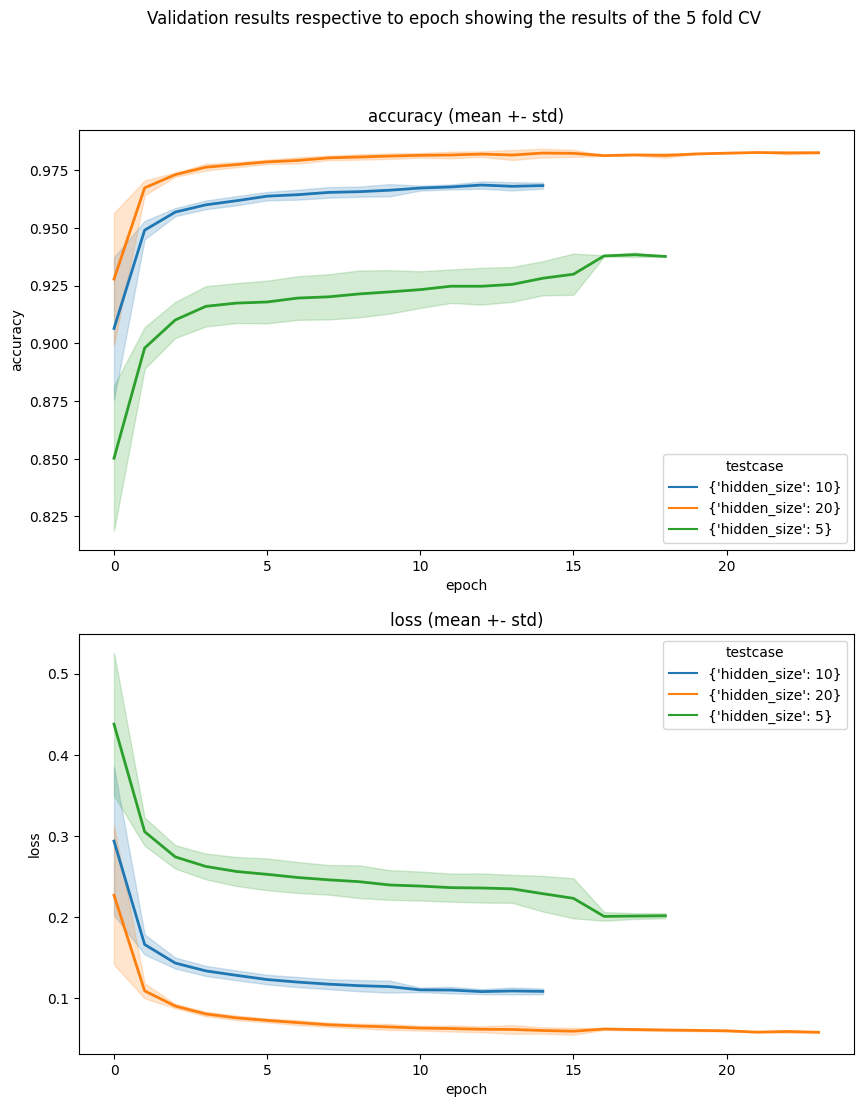

In [7]:
homework_utils.visualisation_with_confidence(
    hiddensize_test_resuts, validation_only=True
)

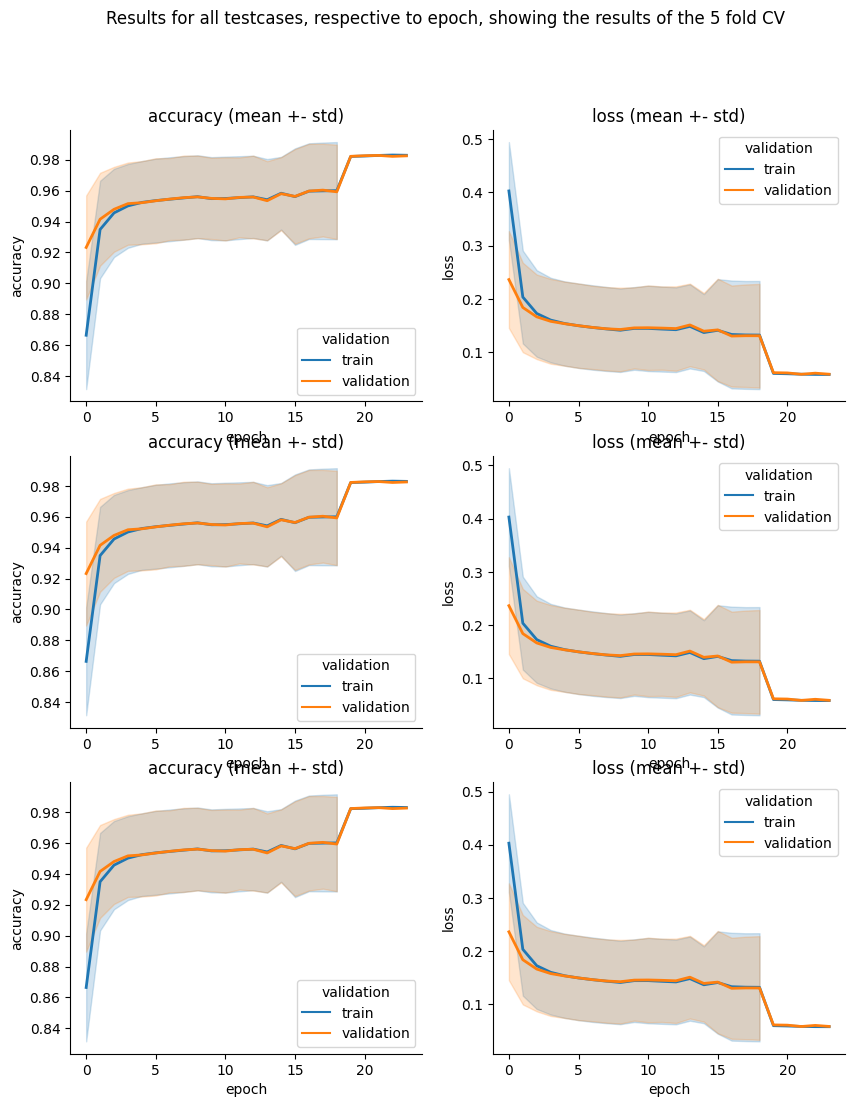

In [8]:
homework_utils.visualisation_with_confidence(
    hiddensize_test_resuts, validation_only=False
)

In [9]:
lr_m_matrice = [
    {"hidden_size": I + O, "lr": 0.001, "m": 0.2},
    {"hidden_size": I + O, "lr": 0.001, "m": 0.6},
    {"hidden_size": I + O, "lr": 0.05, "m": 0.6},
    {"hidden_size": I + O, "lr": 0.1, "m": 0.6},
]

lr_m_test_results = homework_utils.wrap_test_case(
    lr_m_matrice, create_model, df[feature_cols].values, df[target_col].values
)

INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.001, 'm': 0.2}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.001, 'm': 0.6}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.05, 'm': 0.6}
INFO:root:Running testcase {'hidden_size': 20, 'lr': 0.1, 'm': 0.6}


In [10]:
for result in lr_m_test_results:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'hidden_size': 20, 'lr': 0.001, 'm': 0.2}
Validation Cross Entropy: 0.5815 (+/- 0.0057)
Validation MSE: 0.0595 (+/- 0.0005)
Validation Accuracy: 0.8022 (+/- 0.0018)
{'hidden_size': 20, 'lr': 0.001, 'm': 0.6}
Validation Cross Entropy: 0.4784 (+/- 0.0041)
Validation MSE: 0.0495 (+/- 0.0005)
Validation Accuracy: 0.8327 (+/- 0.0024)
{'hidden_size': 20, 'lr': 0.05, 'm': 0.6}
Validation Cross Entropy: 0.0757 (+/- 0.0032)
Validation MSE: 0.0070 (+/- 0.0002)
Validation Accuracy: 0.9782 (+/- 0.0010)
{'hidden_size': 20, 'lr': 0.1, 'm': 0.6}
Validation Cross Entropy: 0.0651 (+/- 0.0029)
Validation MSE: 0.0061 (+/- 0.0002)
Validation Accuracy: 0.9807 (+/- 0.0010)


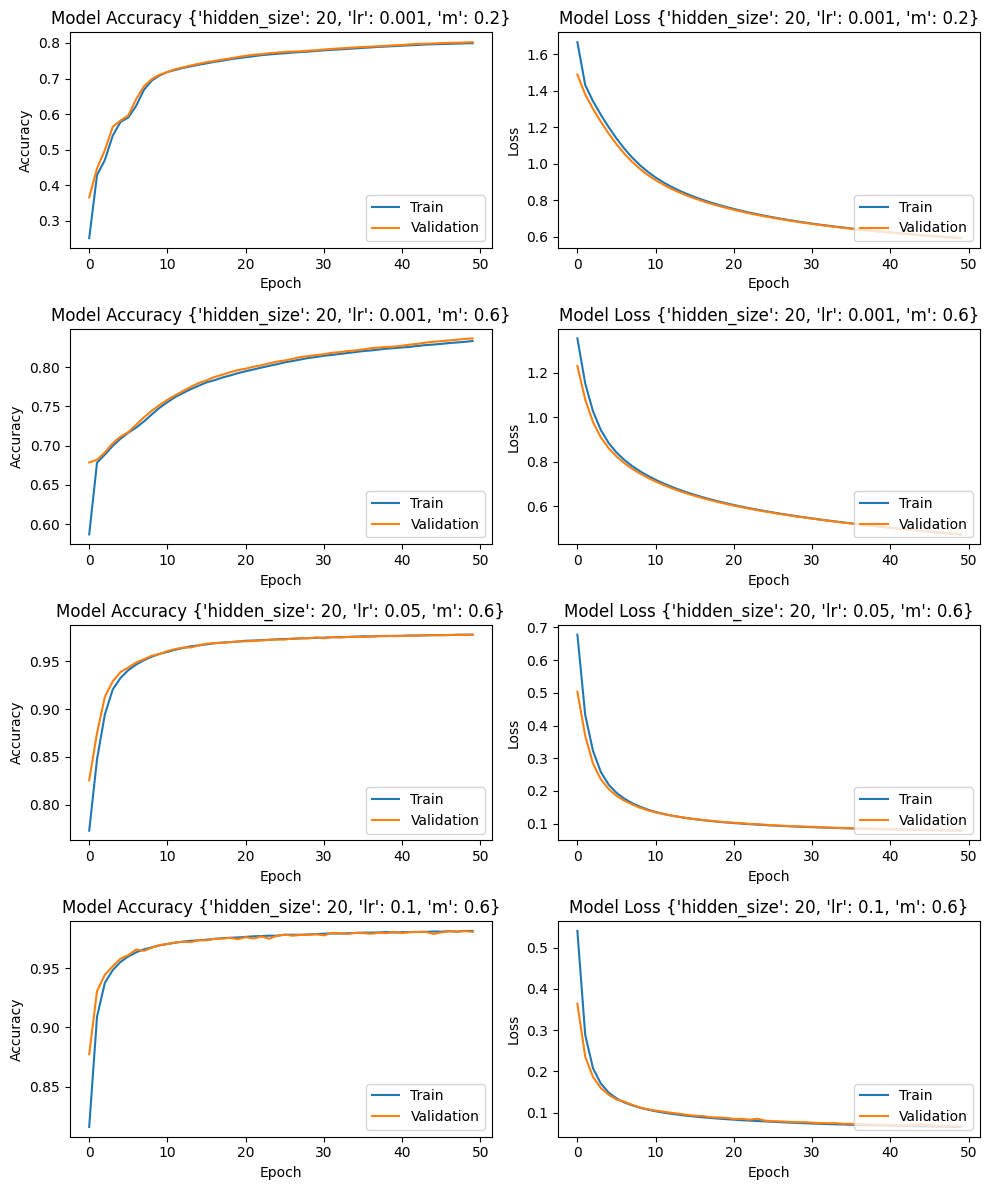

In [11]:
# set up the figure
homework_utils.figure_from_histories(
    [I.histories[0] for I in lr_m_test_results], [I.testcase for I in lr_m_test_results]
)

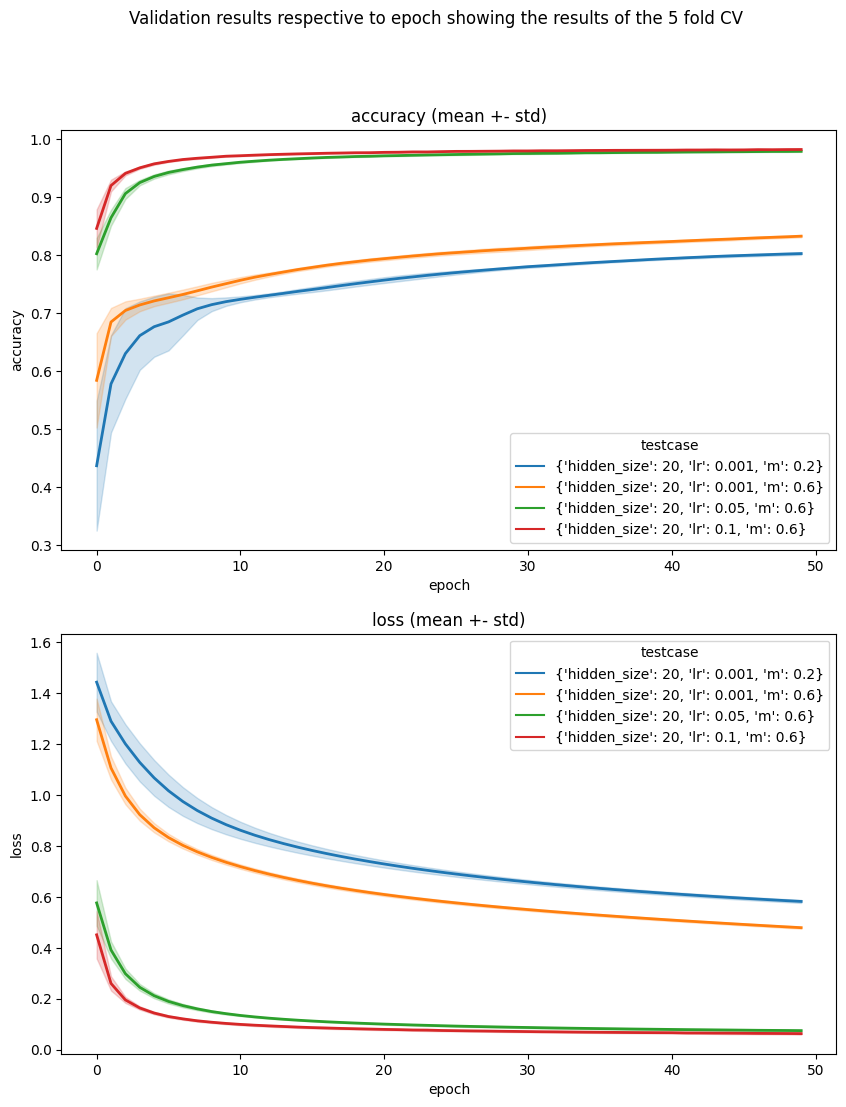

In [12]:
homework_utils.visualisation_with_confidence(lr_m_test_results, validation_only=True)

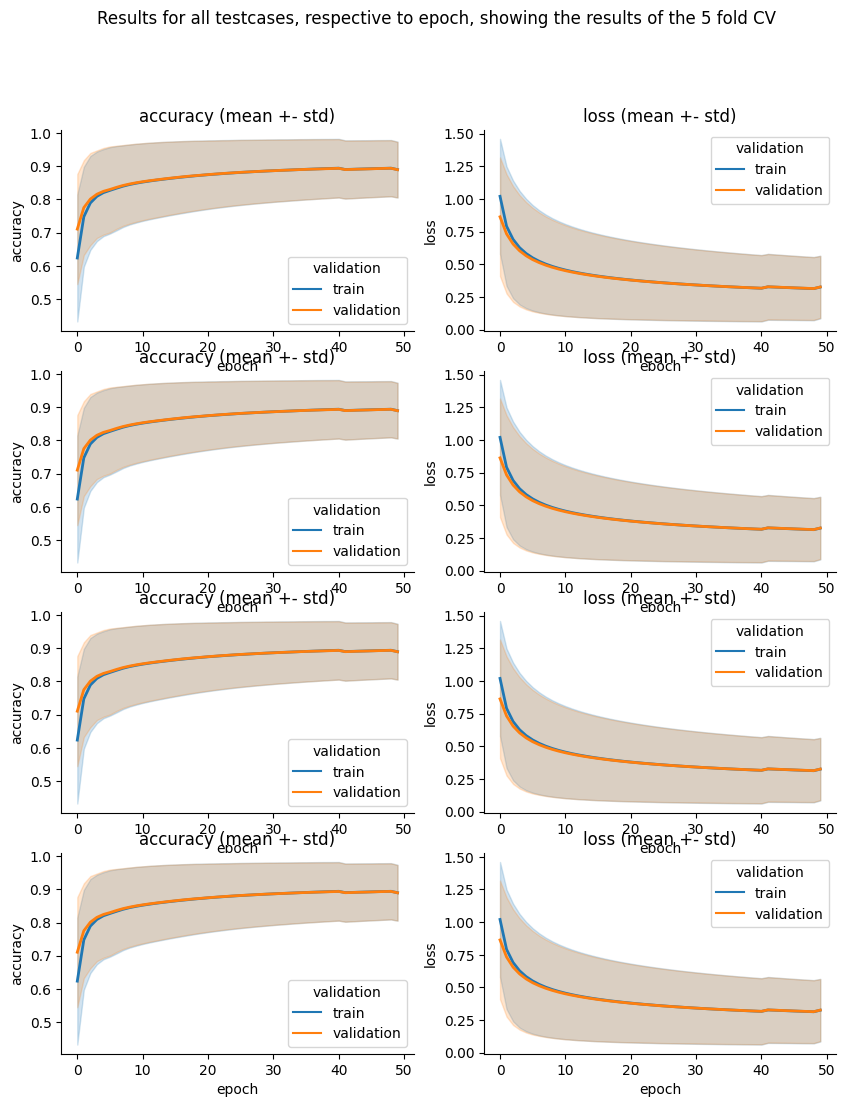

In [13]:
homework_utils.visualisation_with_confidence(lr_m_test_results, validation_only=False)

In [14]:
from keras import regularizers


def create_normalised_model(coef):
    model = Sequential()
    model.add(
        Dense(
            I + O,
            input_dim=len(feature_cols),
            activation="sigmoid",
            bias_regularizer=regularizers.L2(coef),
        )
    )
    model.add(Dense(O, activation="softmax"))
    optimizer = Adam(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_crossentropy", "mean_squared_error", "accuracy"],
    )
    return model

In [15]:
test_matrice_reg = [
    {"coef": 0.1},
    {"coef": 0.5},
    {"coef": 0.9},
]

regularization_test_results = homework_utils.wrap_test_case(
    test_matrice_reg,
    create_normalised_model,
    df[feature_cols].values,
    df[target_col].values,
)

INFO:root:Running testcase {'coef': 0.1}
INFO:root:Running testcase {'coef': 0.5}
INFO:root:Running testcase {'coef': 0.9}


In [16]:
for result in regularization_test_results:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories))
    print("=" * 30)

{'coef': 0.1}
Validation Cross Entropy: 0.0711 (+/- 0.0052)
Validation MSE: 0.0065 (+/- 0.0005)
Validation Accuracy: 0.9798 (+/- 0.0020)
{'coef': 0.5}
Validation Cross Entropy: 0.0737 (+/- 0.0046)
Validation MSE: 0.0068 (+/- 0.0004)
Validation Accuracy: 0.9785 (+/- 0.0012)
{'coef': 0.9}
Validation Cross Entropy: 0.0661 (+/- 0.0025)
Validation MSE: 0.0060 (+/- 0.0003)
Validation Accuracy: 0.9810 (+/- 0.0010)


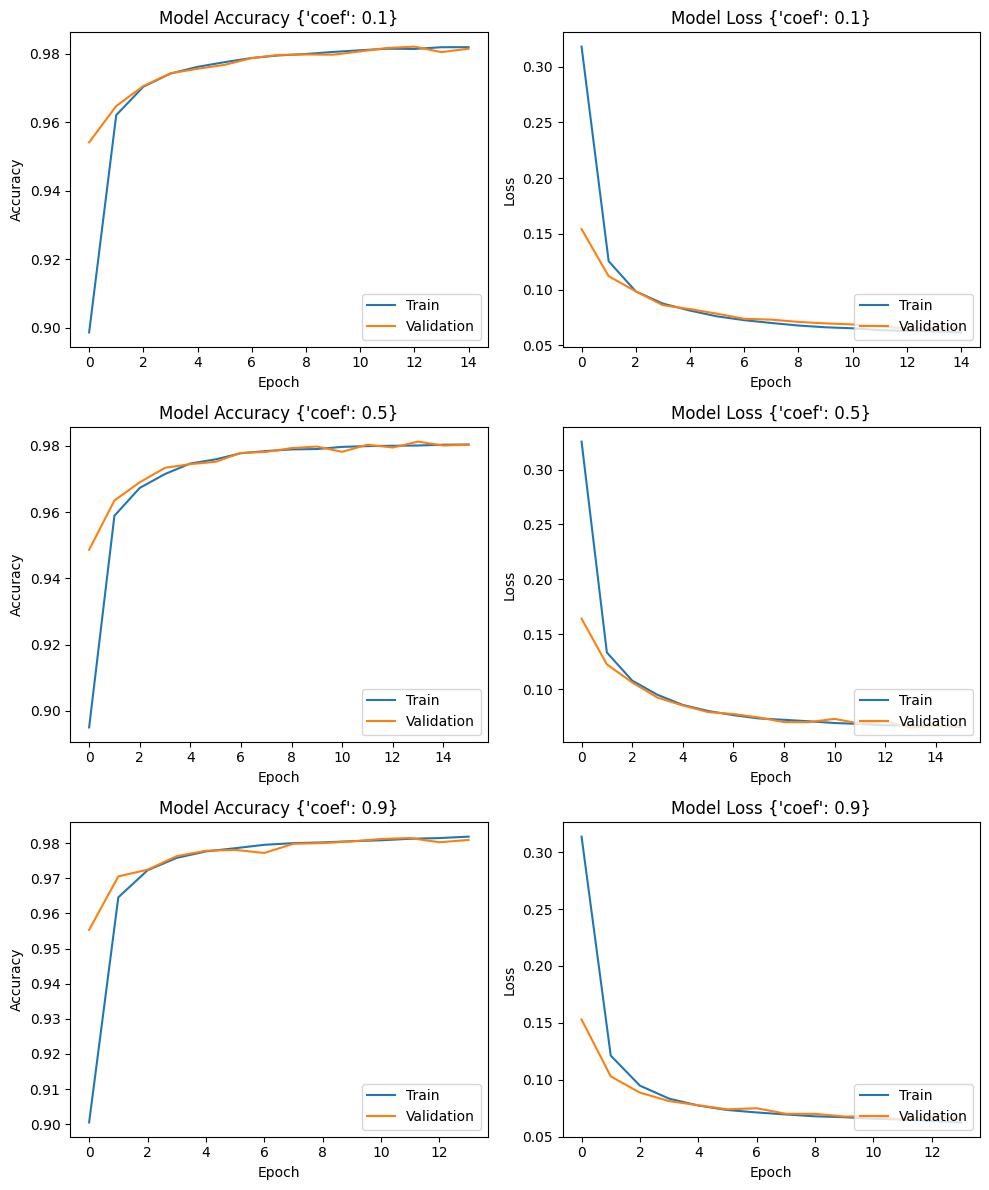

In [17]:
homework_utils.figure_from_histories(
    [I.histories[0] for I in regularization_test_results],
    [I.testcase for I in regularization_test_results],
)

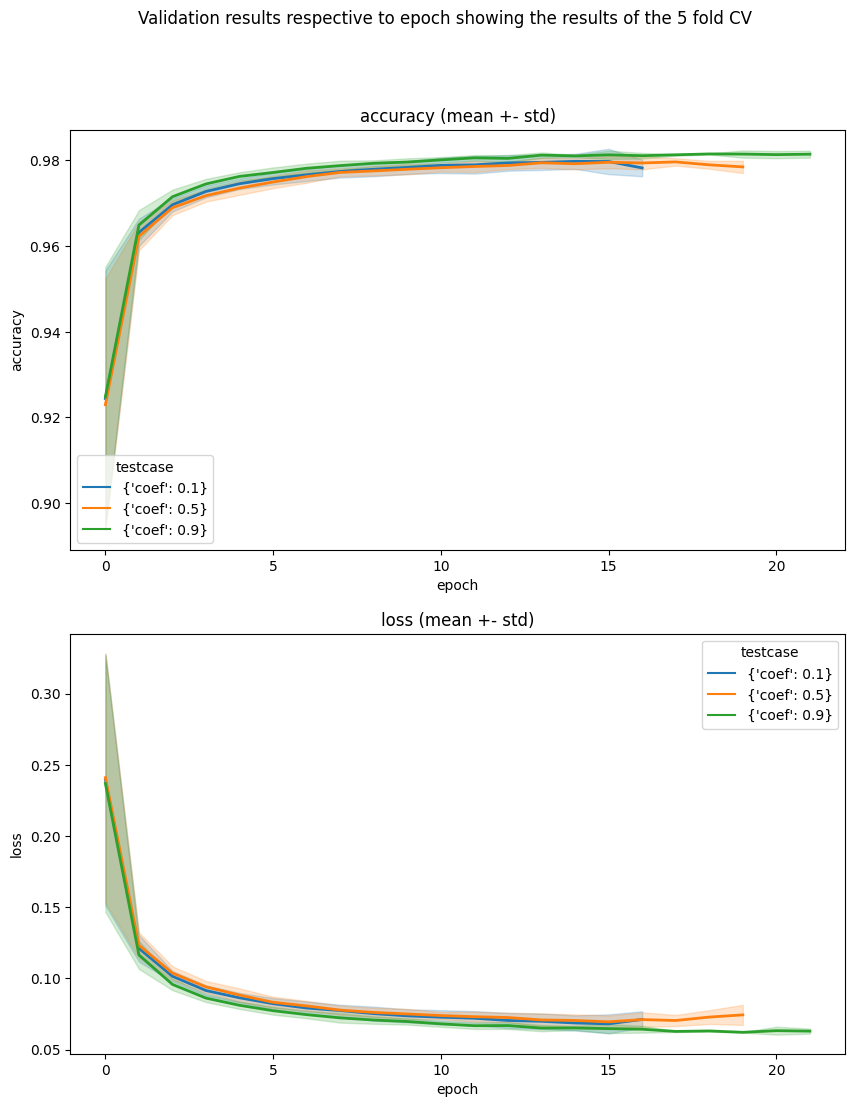

In [18]:
homework_utils.visualisation_with_confidence(
    regularization_test_results, validation_only=True
)

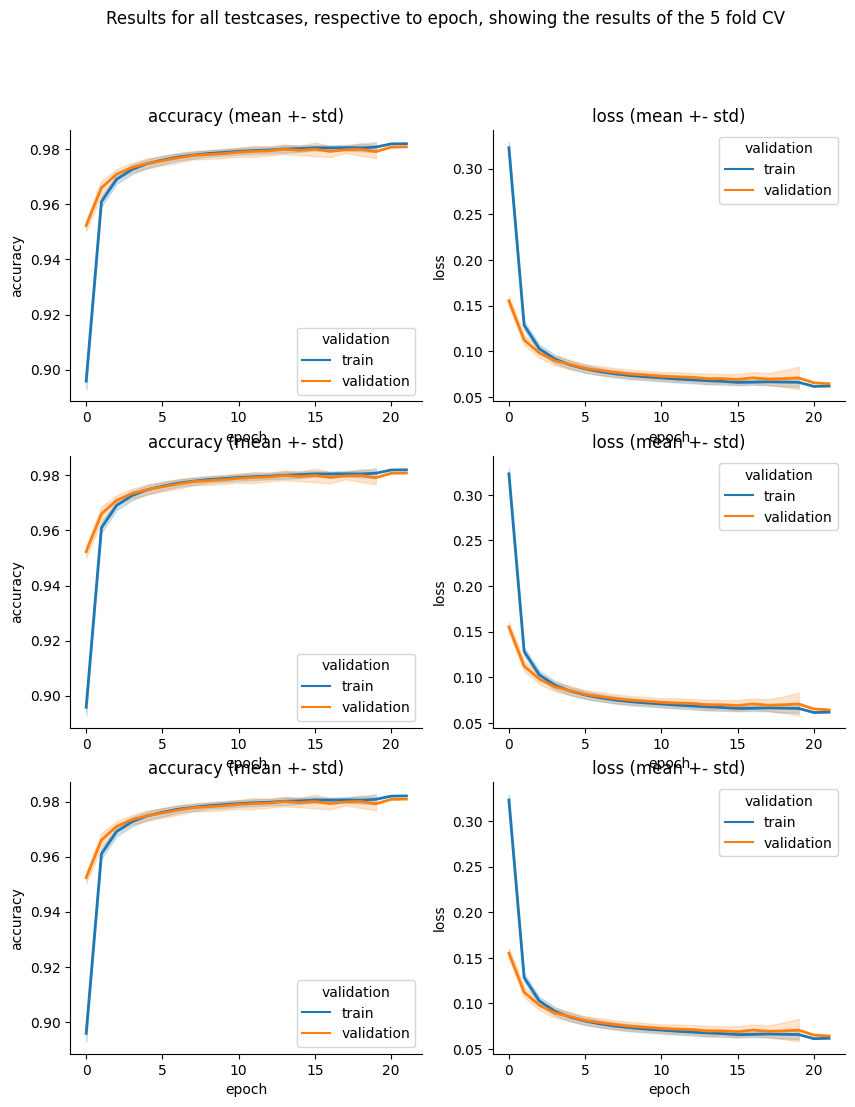

In [19]:
homework_utils.visualisation_with_confidence(
    regularization_test_results, validation_only=False
)

In [20]:
# run generalisation test
df_scaled = pd.read_parquet("dataset/scaled_train_data.parquet")
df_scaled_validation = pd.read_parquet("dataset/scaled_validation_data.parquet")

In [21]:
reload(homework_utils)
hiddensize_test_resuts_ext = homework_utils.wrap_test_case(
    hidden_layer_matrice,
    create_model,
    df_scaled[feature_cols].values,
    df_scaled[target_col].values,
    df_scaled_validation[feature_cols].values,
    df_scaled_validation[target_col].values,
)


INFO:root:Running testcase {'hidden_size': 5}
INFO:root:Running testcase {'hidden_size': 10}
INFO:root:Running testcase {'hidden_size': 20}


In [22]:
for result in hiddensize_test_resuts_ext:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories),validation_only=False)
    print("=" * 30)

{'hidden_size': 5}
Test Cross Entropy: 0.1818 (+/- 0.0000)
Test MSE: 0.0173 (+/- 0.0000)
Test Accuracy: 0.9444 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 7.5259 (+/- 0.0000)
Validation MSE: 0.2779 (+/- 0.0000)
Validation Accuracy: 0.1394 (+/- 0.0000)
{'hidden_size': 10}
Test Cross Entropy: 0.0804 (+/- 0.0000)
Test MSE: 0.0074 (+/- 0.0000)
Test Accuracy: 0.9767 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 2.6792 (+/- 0.0000)
Validation MSE: 0.2160 (+/- 0.0000)
Validation Accuracy: 0.3631 (+/- 0.0000)
{'hidden_size': 20}
Test Cross Entropy: 0.0397 (+/- 0.0000)
Test MSE: 0.0037 (+/- 0.0000)
Test Accuracy: 0.9881 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 2.0756 (+/- 0.0000)
Validation MSE: 0.1584 (+/- 0.0000)
Validation Accuracy: 0.5112 (+/- 0.0000)


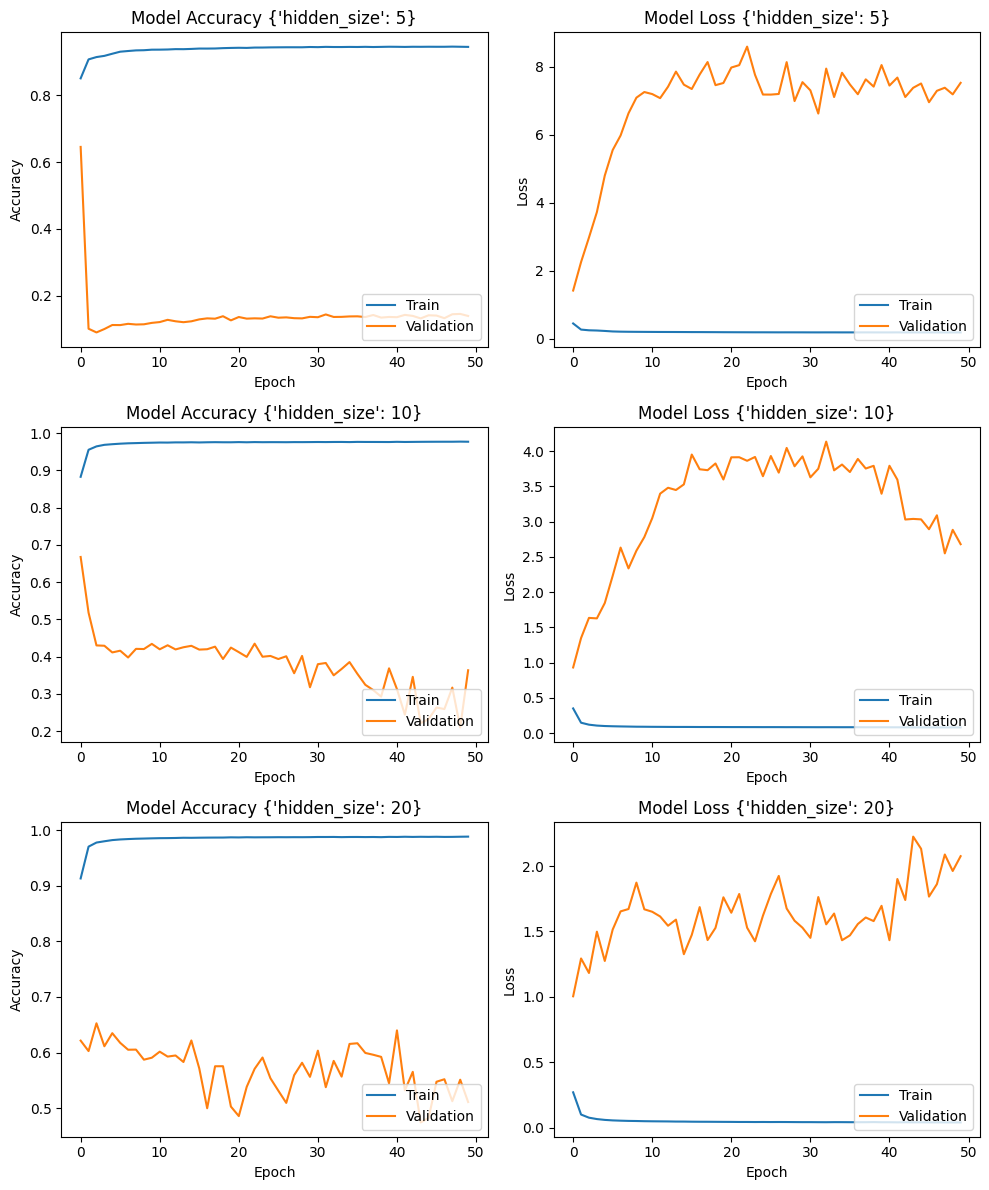

In [23]:
homework_utils.figure_from_histories(
    [I.histories[0] for I in hiddensize_test_resuts_ext],
    [I.testcase for I in hiddensize_test_resuts_ext],
)

In [24]:
def create_normalised_model_extended(hidden_size,coef,mode=None):
    model = Sequential()
    model.add(
        Dense(
            hidden_size,
            input_dim=len(feature_cols),
            activation="sigmoid",
            bias_regularizer= regularizers.L2(coef) if mode == 'l2' else regularizers.L1(coef),
        )
    )
    model.add(Dense(O, activation="softmax"))
    optimizer = Adam(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["categorical_crossentropy", "mean_squared_error", "accuracy"],
    )
    return model

In [25]:
coefs = [0.1,0.5,0.9]
modes = ['l1','l2']
hdsizes = [5,7,9]
test_matrice_reg_2 = list()
for hs in hdsizes:
    for c in coefs:
        for mode in modes:
            test_matrice_reg_2.append(
                {'hidden_size':hs,'coef':c,'mode':mode}
            )

In [26]:
regularization_test_results_ext = homework_utils.wrap_test_case(
    test_matrice_reg_2,
    create_normalised_model_extended,
    df[feature_cols].values,
    df[target_col].values,
    df_scaled_validation[feature_cols].values,
    df_scaled_validation[target_col].values,
)


INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.1, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.1, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.5, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.5, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.9, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 5, 'coef': 0.9, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.1, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.1, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.5, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.5, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.9, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 7, 'coef': 0.9, 'mode': 'l2'}
INFO:root:Running testcase {'hidden_size': 9, 'coef': 0.1, 'mode': 'l1'}
INFO:root:Running testcase {'hidden_size': 9, 'coef

In [27]:
for result in regularization_test_results_ext:
    print(result.testcase)
    homework_utils.print_scores(homework_utils.score_from_histories(result.histories),validation_only=False)
    print("=" * 30)

{'hidden_size': 5, 'coef': 0.1, 'mode': 'l1'}
Test Cross Entropy: 0.5898 (+/- 0.0000)
Test MSE: 0.0603 (+/- 0.0000)
Test Accuracy: 0.7991 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 2.2999 (+/- 0.0000)
Validation MSE: 0.1392 (+/- 0.0000)
Validation Accuracy: 0.5144 (+/- 0.0000)
{'hidden_size': 5, 'coef': 0.1, 'mode': 'l2'}
Test Cross Entropy: 0.4842 (+/- 0.0000)
Test MSE: 0.0468 (+/- 0.0000)
Test Accuracy: 0.8537 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 1.0072 (+/- 0.0000)
Validation MSE: 0.0908 (+/- 0.0000)
Validation Accuracy: 0.6259 (+/- 0.0000)
{'hidden_size': 5, 'coef': 0.5, 'mode': 'l1'}
Test Cross Entropy: 0.4445 (+/- 0.0000)
Test MSE: 0.0432 (+/- 0.0000)
Test Accuracy: 0.8529 (+/- 0.0000)
------------------------------
Validation Cross Entropy: 1.2190 (+/- 0.0000)
Validation MSE: 0.0920 (+/- 0.0000)
Validation Accuracy: 0.6697 (+/- 0.0000)
{'hidden_size': 5, 'coef': 0.5, 'mode': 'l2'}
Test Cross Entropy: 0.4755 (+/- 0.0000)

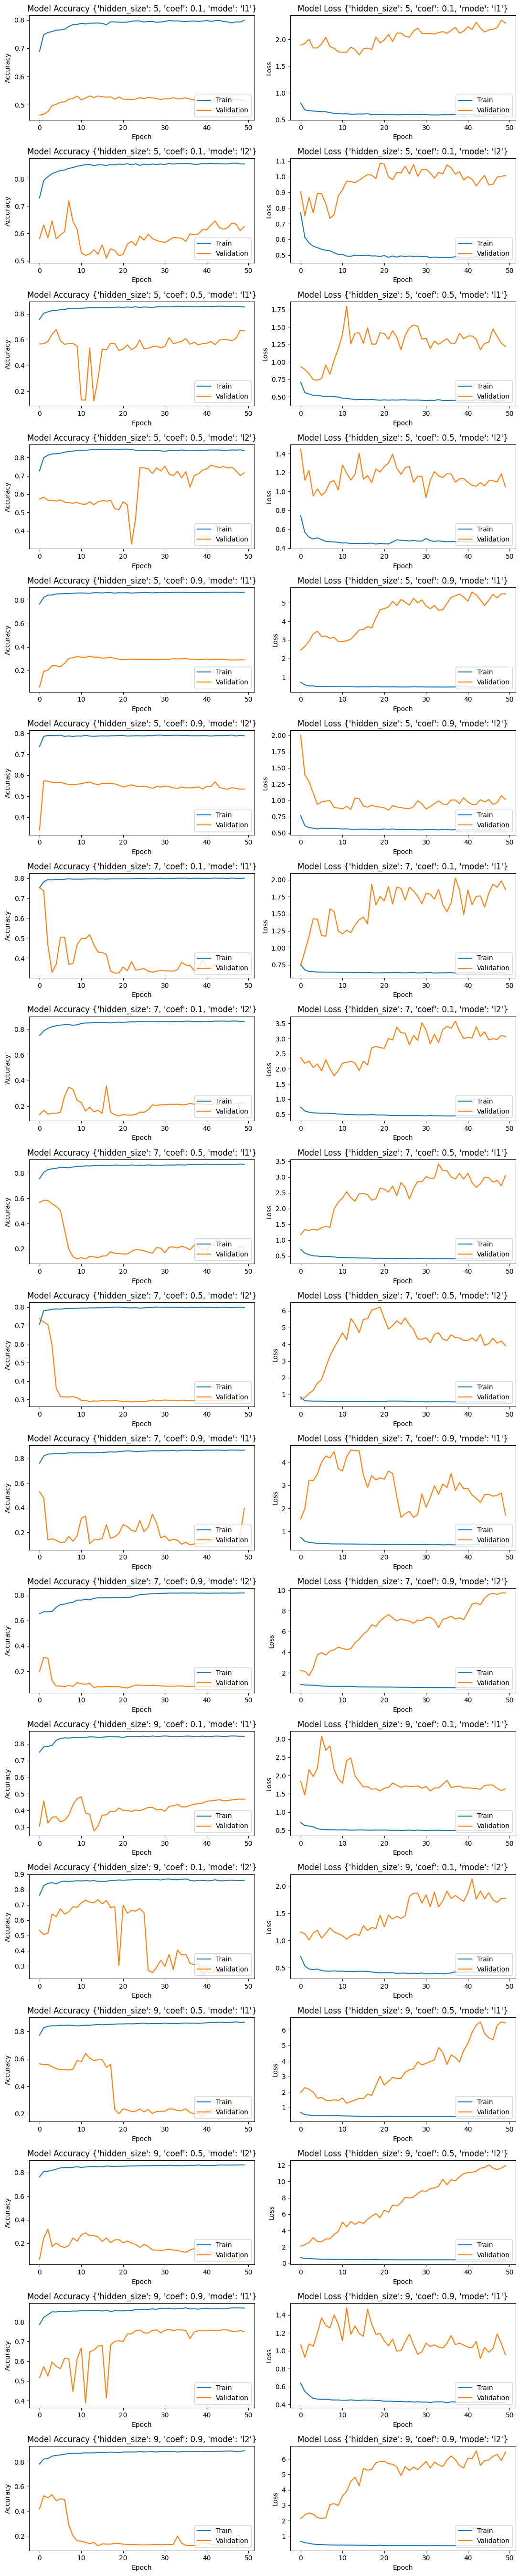

In [31]:
reload(homework_utils)
homework_utils.figure_from_histories(
    [I.histories[0] for I in regularization_test_results_ext],
    [I.testcase for I in regularization_test_results_ext],
)